In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from iactrace import (
    Telescope, MCIntegrator, hexshow
)

# Import HESS I telescope configuration:

In [28]:
%%time
integrator = MCIntegrator(128, 20.0) # This defines the sampler to sample N points per mirror facet, also defining microfacet roughness
telescope = Telescope.from_yaml('../configs/HESS/CT5.yaml', integrator, sampling_key = jax.random.key(42))

CPU times: user 48.7 s, sys: 10.9 s, total: 59.6 s
Wall time: 42.3 s


# Simulating Star field:

In [51]:
# Generate star field
n_stars = 1
key = jax.random.key(42)
key1, key2 = jax.random.split(key)

# Small angular region (3 degrees field of view)
fov_deg = 3
fov_rad = fov_deg * jnp.pi / 180

x = jax.random.uniform(key1, (n_stars,), minval=-fov_rad/2, maxval=fov_rad/2)
y = jax.random.uniform(key2, (n_stars,), minval=-fov_rad/2, maxval=fov_rad/2)
z = -jnp.ones(n_stars)

stars = jnp.stack([x, y, z], axis=1)
stars = stars / jnp.linalg.norm(stars, axis=1, keepdims=True)

In [55]:
%%time
image_flashcam = telescope(stars, source_type='infinity', sensor_idx=0).block_until_ready()
image_hess2 = telescope(stars, source_type='infinity', sensor_idx=1).block_until_ready()
image_lid = telescope(stars, source_type='infinity', sensor_idx=2).block_until_ready()

CPU times: user 717 ms, sys: 30.6 ms, total: 748 ms
Wall time: 919 ms


<Axes: >

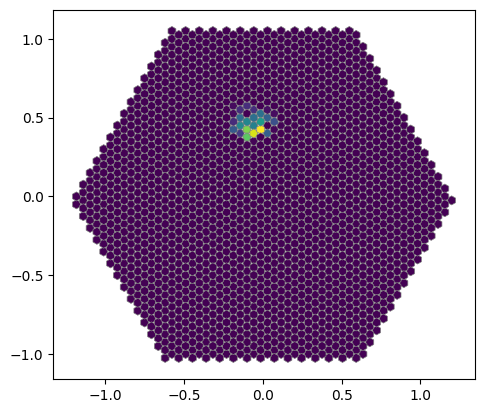

In [58]:
hexshow(image_flashcam, telescope.sensors[0].hex_centers)

# Simulating Point Source:

In [11]:
N_points = 1

key = jax.random.key(12)
key1, key2 = jax.random.split(key)

x = jax.random.uniform(key1, N_points, minval=-1, maxval=1)
y = jax.random.uniform(key2, N_points, minval=-1, maxval=1)
z = jnp.ones(N_points) * 750

points = jnp.array([x,y,z]).T

In [12]:
%%time
image_lid = telescope(points, source_type='point', sensor_idx=2).block_until_ready()

CPU times: user 10.1 ms, sys: 1 ms, total: 11.1 ms
Wall time: 36.8 ms


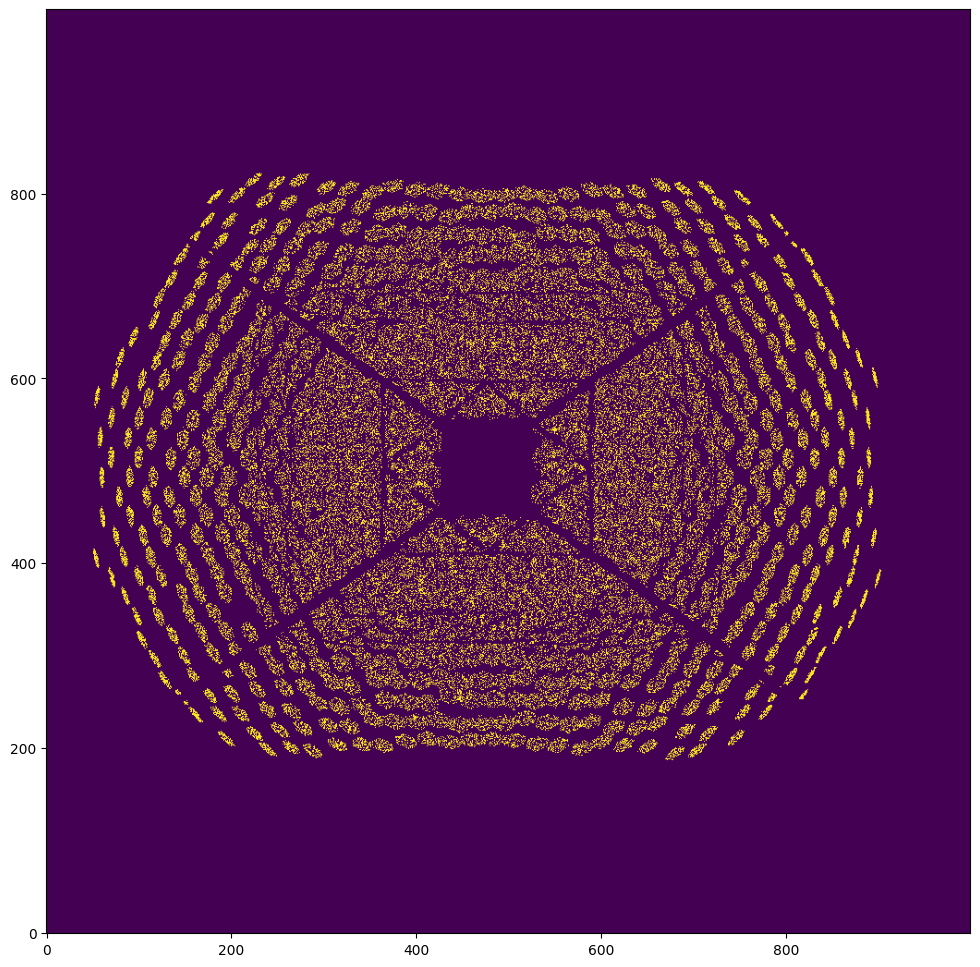

In [13]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(image_lid, origin='lower', vmax=1)